# Перенос обучения и сравнение архитектур в Pytorch

## Импорт необходимых библиотек

In [ ]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

In [ ]:
def torch_stats():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')
        # dtype = torch.cuda.FloatTensor

    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn

In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.0
Using device: cuda
cuda:  2.0.0
Cuda is available: True
number of devices: 2
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers (CPU cores): 4


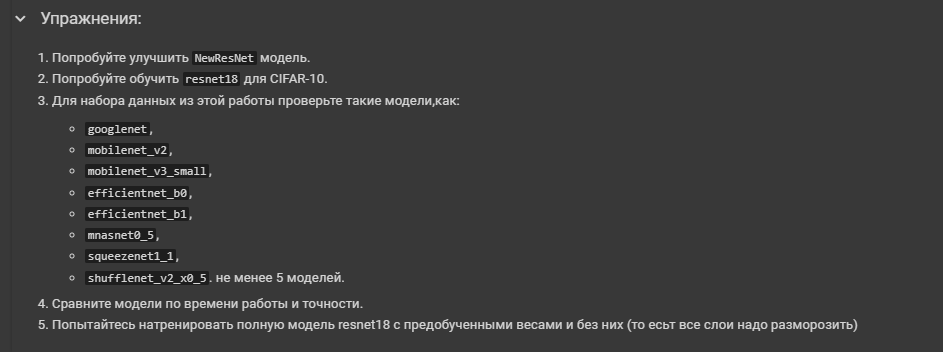

## 1. Попробуйте улучшить NewResNet

Загрузим данные

In [ ]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

Using downloaded and verified file: /kaggle/working/data/hymenoptera_data.zip
Extracting /kaggle/working/data/hymenoptera_data.zip to /kaggle/working/data


In [ ]:
content = os.listdir(dataset_directory)
print(content)
for dir_ in content:
    path_ = os.path.join(dataset_directory,dir_)
    if os.path.isdir(path_):
        print(dir_, ':\t', os.listdir(path_ ) )

['train', 'val']
train :	 ['ants', 'bees']
val :	 ['ants', 'bees']


In [ ]:
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),train_transform)

valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'),test_transform)

names_classes = traindata.classes
print(names_classes)

print(f'Number of training examples: {len(traindata)}')
print(f'Number of validation examples: {len(valdata)}')

['ants', 'bees']
Number of training examples: 244
Number of validation examples: 153


In [ ]:
BATCH_SIZE = 4
if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'num_workers':min(BATCH_SIZE, num_workers)}

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, **kwarg)

valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, **kwarg)

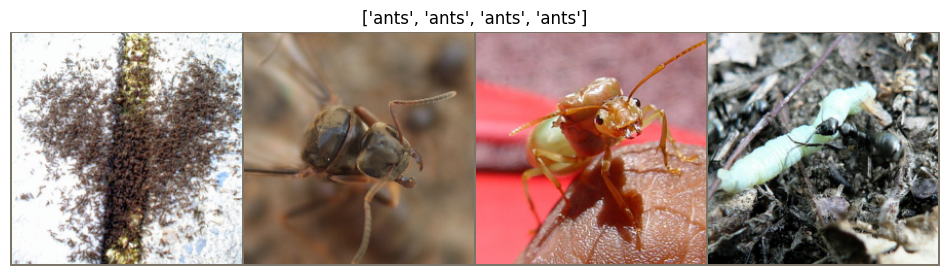

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(valloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[names_classes[x] for x in classes])

In [ ]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

#-----------------------------
def train(model, dataloader, optimizer, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Добавим в архитектуру два слоя - Dropout и BatchNorm2d

In [ ]:
class NewResNet(nn.Module):
    def __init__(self, model, n_features=512, n_classes=2, cutlayer =2):
        super().__init__()

        self.new_model_ = nn.Sequential(*list(model.children())[:-cutlayer])

        for param in self.new_model_.parameters():
            param.requires_grad = False

        self.conv_last  = nn.Conv2d(in_channels  = n_features,
                                    out_channels = 256,
                                    kernel_size  = 3,
                                    stride       = 1,
                                    padding      = 1,
                                    dilation     = 1)

        self.batch_norm = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.3)

        # self.conv_last.apply(self.init_weights)

        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.fc  = nn.Linear(in_features = 256,
                                out_features = n_classes)

        for m in [self.conv_last, self.fc]:
            m.apply(self.init_weights)

    #---------------------------------------------
    def init_weights(self, m):

        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if m.bias != None:
                m.bias.data.fill_(0)

    #---------------------------------------------
    def forward(self,x):
        x = self.new_model_(x)

        x = torch.relu(self.conv_last(x))
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


Посмотрим на архитектуру

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

new_model = NewResNet(model)
summary(new_model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
LR = 0.001

new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [ ]:
trainable_parameters = []
for p in new_model.parameters():
    if p.requires_grad:
        trainable_parameters +=[p]

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(new_model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 0: Test Loss: 0.831 | Test Acc: 54.49%


In [ ]:
EPOCHS = 30

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(new_model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(new_model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(new_model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

new_model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(new_model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.403 | Train Acc: 79.51%
	 Val. Loss: 0.193 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.319 | Train Acc: 86.07%
	 Val. Loss: 0.227 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.369 | Train Acc: 82.79%
	 Val. Loss: 0.164 |  Val. Acc: 96.15%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.341 | Train Acc: 82.79%
	 Val. Loss: 0.252 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.336 | Train Acc: 85.25%
	 Val. Loss: 0.328 |  Val. Acc: 86.54%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.403 | Train Acc: 81.97%
	 Val. Loss: 0.230 |  Val. Acc: 89.10%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.312 | Train Acc: 88.93%
	 Val. Loss: 0.214 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.258 | Train Acc: 90.57%
	 Val. Loss: 0.198 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.317 | Train Acc: 87.30%
	 Val. Loss: 0.217 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.353 | Train Acc: 86.07%
	 Val. Loss: 0.176 |  Val. Acc: 94.23%


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 5: Test Loss: 0.164 | Test Acc: 96.15%


In [ ]:
new_model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(new_model, valloader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 5: Test Loss: 0.164 | Test Acc: 96.15%


Улучшение на 2% по сравнению с исходным вариантом!

## 2. Попробуйте обучить resnet18 для CIFAR-10.

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name,_ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.Resize(36),
                            transforms.RandomRotation(5),
                            transforms.RandomHorizontalFlip(0.5),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ColorJitter(brightness=0.5,
                                                   contrast=0.5,
                                                   saturation=0.5,
                                                   hue=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=mean, std=std)
                                     ])

Загружаем данные CIFAR10

в отличие от предыдущего примера, где было два класса - пчела и муравей, здесь мы имеем 10 классов, что может сказать на качестве. Стоить отметить в предыдущей работе LeNet (улучшенная версия) - accuracy= 60%

In [ ]:


trainset = torchvision.datasets.CIFAR10(root      = './data',
                                        train     = True,
                                        download  = True,
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data',
                                       train     = False,
                                       download  = True,
                                       transform = test_transforms)


names_classes = trainset.classes
print(names_classes)

print(f'Number of training examples: {len(trainset )}')
print(f'Number of validation examples: {len(testset)}')

100%|██████████| 170498071/170498071 [00:03<00:00, 49677728.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of training examples: 50000
Number of validation examples: 10000


In [ ]:
BATCH_SIZE = 128

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              **kwarg)


valloader  = data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False, **kwarg)

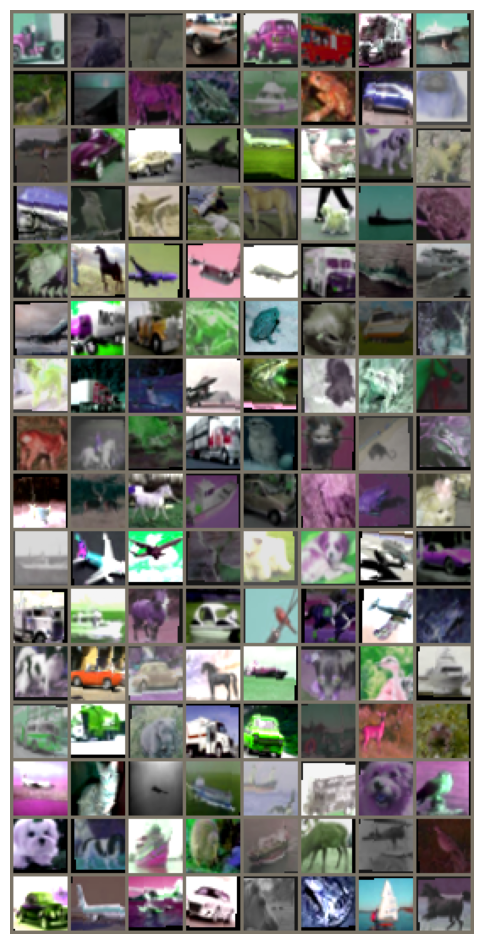

first raw classes truck  deer  deer automobile automobile truck truck  ship  deer  ship horse  frog  ship  frog automobile   dog
torch.Size([128, 3, 32, 32])


In [ ]:
def imshow(images, mean=mean, std=std):
    img = torchvision.utils.make_grid(images).to(device)
    img = img.transpose(2,0).transpose(0,1)
    img = (img * torch.as_tensor(std).to(device)
               + torch.as_tensor(mean).to(device) )# unnormalize
    img = img.data.cpu().numpy()

    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [ ]:
n_classes

10

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 5130
Number of all parameters for the model: 11181642


In [ ]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

best epoch 0: Test Loss: 3.077 | Test Acc: 9.69%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 39s
	Train Loss: 2.119 | Train Acc: 26.73%
	 Val. Loss: 2.004 |  Val. Acc: 32.16%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 38s
	Train Loss: 1.978 | Train Acc: 30.65%
	 Val. Loss: 1.863 |  Val. Acc: 36.14%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 39s
	Train Loss: 1.933 | Train Acc: 32.28%
	 Val. Loss: 1.807 |  Val. Acc: 38.22%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 39s
	Train Loss: 1.912 | Train Acc: 33.06%
	 Val. Loss: 1.789 |  Val. Acc: 38.40%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 38s
	Train Loss: 1.899 | Train Acc: 33.24%
	 Val. Loss: 1.761 |  Val. Acc: 39.71%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 38s
	Train Loss: 1.893 | Train Acc: 33.48%
	 Val. Loss: 1.761 |  Val. Acc: 39.31%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 37s
	Train Loss: 1.885 | Train Acc: 33.90%
	 Val. Loss: 1.770 |  Val. Acc: 39.18%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 38s
	Train Loss: 1.883 | Train Acc: 33.87%
	 Val. Loss: 1.747 |  Val. Acc: 39.88%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 37s
	Train Loss: 1.873 | Train Acc: 33.88%
	 Val. Loss: 1.745 |  Val. Acc: 40.45%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 37s
	Train Loss: 1.883 | Train Acc: 33.86%
	 Val. Loss: 1.736 |  Val. Acc: 40.54%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

-------------------- 
best epoch 16: Test Loss: 1.732 | Test Acc: 40.05%


Accuracy = 40%, LeNet в предыдущей работе (без модификаций) accuracy = 52%. Можно предположить, что метрика упала так как архитектура показывает себя на этих данных хуже, или не хватило эпох для обучения (хотя рассматривался вариант с 30 эпохами и разницы не было)

## 3. Для набора данных из этой работы проверьте такие модели,как:
    * `googlenet`,
    * `mobilenet_v2`,  
    * `efficientnet_b1`,
    * `mnasnet0_5`,  
    * `shufflenet_v2_x0_5`.

Заново загрузим данные

In [ ]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

Using downloaded and verified file: /kaggle/working/data/hymenoptera_data.zip
Extracting /kaggle/working/data/hymenoptera_data.zip to /kaggle/working/data


In [ ]:
content = os.listdir(dataset_directory)
print(content)
for dir_ in content:
    path_ = os.path.join(dataset_directory,dir_)
    if os.path.isdir(path_):
        print(dir_, ':\t', os.listdir(path_ ) )

['train', 'val']
train :	 ['bees', 'ants']
val :	 ['bees', 'ants']


In [ ]:
train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),train_transform)

valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'),test_transform)

names_classes = traindata.classes
print(names_classes)

print(f'Number of training examples: {len(traindata)}')
print(f'Number of validation examples: {len(valdata)}')

['ants', 'bees']
Number of training examples: 244
Number of validation examples: 153


In [ ]:
BATCH_SIZE = 4
if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'num_workers':min(BATCH_SIZE, num_workers)}

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, **kwarg)

valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, **kwarg)



### `googlenet`

In [ ]:
model = torchvision.models.googlenet(pretrained=True)
summary(model,input_size=(3, 32, 32))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 86.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
       BasicConv2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 192, 8, 8]         110,592
       BatchNorm2d-9            [-1, 192, 8, 8]             384
      BasicConv2d-10            [-1, 192, 8, 8]               0
        MaxPool2d-11            [-1, 192, 4, 4]               0
           Conv2d-12             [-1, 64, 4, 4]          12,288
      BatchNorm2d-13             [-1, 64, 4, 4]             128
      BasicConv2d-14             [-1, 6

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 2050
Number of all parameters for the model: 5601954


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 0.929 | Test Acc: 27.56%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.531 | Train Acc: 71.72%
	 Val. Loss: 0.340 |  Val. Acc: 86.54%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.472 | Train Acc: 75.00%
	 Val. Loss: 0.260 |  Val. Acc: 91.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.455 | Train Acc: 77.05%
	 Val. Loss: 0.230 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.358 | Train Acc: 81.56%
	 Val. Loss: 0.222 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.517 | Train Acc: 72.13%
	 Val. Loss: 0.243 |  Val. Acc: 91.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.444 | Train Acc: 77.05%
	 Val. Loss: 0.220 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.375 | Train Acc: 79.51%
	 Val. Loss: 0.268 |  Val. Acc: 89.74%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.447 | Train Acc: 81.56%
	 Val. Loss: 0.209 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.390 | Train Acc: 83.20%
	 Val. Loss: 0.252 |  Val. Acc: 90.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.480 | Train Acc: 75.00%
	 Val. Loss: 0.234 |  Val. Acc: 89.74%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 15: Test Loss: 0.209 | Test Acc: 91.67%


### `mobilenet_v2`

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True)
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name,_ in model.named_children():
    print(name)

features
classifier


In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.classifier[1].in_features

model.classifier = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.classifier.weight)
model.classifier.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 2562
Number of all parameters for the model: 2226434


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 1.096 | Test Acc: 46.79%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.438 | Train Acc: 78.28%
	 Val. Loss: 0.202 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.461 | Train Acc: 78.69%
	 Val. Loss: 0.169 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.452 | Train Acc: 82.79%
	 Val. Loss: 0.180 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.254 | Train Acc: 89.75%
	 Val. Loss: 0.207 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.241 | Train Acc: 89.75%
	 Val. Loss: 0.236 |  Val. Acc: 89.10%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 2s
	Train Loss: 0.369 | Train Acc: 84.84%
	 Val. Loss: 0.202 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.366 | Train Acc: 86.07%
	 Val. Loss: 0.235 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 2s
	Train Loss: 0.397 | Train Acc: 86.07%
	 Val. Loss: 0.177 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 2s
	Train Loss: 0.389 | Train Acc: 84.84%
	 Val. Loss: 0.139 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 2s
	Train Loss: 0.374 | Train Acc: 82.79%
	 Val. Loss: 0.186 |  Val. Acc: 93.59%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 17: Test Loss: 0.139 | Test Acc: 94.87%


### `efficientnet_b1`

In [ ]:
model = torchvision.models.efficientnet_b1(pretrained=True)
summary(model,input_size=(3, 32, 32))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 76.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              SiLU-6           [-1, 32, 16, 16]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 16, 16, 16]             512
      BatchNorm2d-14           [-1, 16,

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name,_ in model.named_children():
    print(name)

features
avgpool
classifier


In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.classifier[1].in_features

model.classifier = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.classifier.weight)
model.classifier.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 2562
Number of all parameters for the model: 6515746


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 0.890 | Test Acc: 48.72%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.495 | Train Acc: 73.77%
	 Val. Loss: 0.362 |  Val. Acc: 88.46%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.406 | Train Acc: 80.33%
	 Val. Loss: 0.282 |  Val. Acc: 91.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.374 | Train Acc: 84.02%
	 Val. Loss: 0.260 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.406 | Train Acc: 80.33%
	 Val. Loss: 0.271 |  Val. Acc: 91.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.468 | Train Acc: 76.23%
	 Val. Loss: 0.248 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.374 | Train Acc: 81.97%
	 Val. Loss: 0.256 |  Val. Acc: 90.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.411 | Train Acc: 81.97%
	 Val. Loss: 0.250 |  Val. Acc: 90.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.392 | Train Acc: 81.15%
	 Val. Loss: 0.231 |  Val. Acc: 91.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.329 | Train Acc: 86.89%
	 Val. Loss: 0.234 |  Val. Acc: 90.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.358 | Train Acc: 83.61%
	 Val. Loss: 0.198 |  Val. Acc: 92.95%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 19: Test Loss: 0.198 | Test Acc: 92.95%


### `mnasnet0_5`

In [ ]:
model = torchvision.models.mnasnet0_5(pretrained=True)
summary(model,input_size=(3, 32, 32))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet0_5_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to /root/.cache/torch/hub/checkpoints/mnasnet0.5_top1_67.823-3ffadce67e.pth
100%|██████████| 8.59M/8.59M [00:00<00:00, 75.5MB/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             432
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             144
       BatchNorm2d-5           [-1, 16, 16, 16]              32
              ReLU-6           [-1, 16, 16, 16]               0
            Conv2d-7            [-1, 8, 16, 16]             128
       BatchNorm2d-8            [-1, 8, 16, 16]              16
            Conv2d-9           [-1, 24, 16, 16]             192
      BatchNorm2d-10           [-1, 24, 16, 16]              48
             ReLU-11           [-1, 24, 16, 16]               0
           Conv2d-12             [-1, 24, 8, 8]             216
      BatchNorm2d-13             [-1, 24, 8, 8]              48
             ReLU-14             [-1, 2

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name,_ in model.named_children():
    print(name)

layers
classifier


In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.classifier[1].in_features

model.classifier = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.classifier.weight)
model.classifier.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 2562
Number of all parameters for the model: 940074


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 0.686 | Test Acc: 57.69%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.673 | Train Acc: 65.57%
	 Val. Loss: 0.648 |  Val. Acc: 76.92%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.656 | Train Acc: 68.03%
	 Val. Loss: 0.618 |  Val. Acc: 81.41%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.639 | Train Acc: 71.31%
	 Val. Loss: 0.584 |  Val. Acc: 87.18%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.612 | Train Acc: 80.33%
	 Val. Loss: 0.549 |  Val. Acc: 91.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 0.595 | Train Acc: 78.28%
	 Val. Loss: 0.521 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 2s
	Train Loss: 0.579 | Train Acc: 79.92%
	 Val. Loss: 0.496 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 2s
	Train Loss: 0.576 | Train Acc: 79.51%
	 Val. Loss: 0.476 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 2s
	Train Loss: 0.555 | Train Acc: 81.15%
	 Val. Loss: 0.456 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 2s
	Train Loss: 0.547 | Train Acc: 84.43%
	 Val. Loss: 0.439 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 2s
	Train Loss: 0.540 | Train Acc: 79.92%
	 Val. Loss: 0.423 |  Val. Acc: 94.23%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 19: Test Loss: 0.423 | Test Acc: 94.23%


### `shufflenet_v2_x0_5`

In [ ]:
model = torchvision.models.mnasnet0_5(pretrained=True)
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             432
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             144
       BatchNorm2d-5           [-1, 16, 16, 16]              32
              ReLU-6           [-1, 16, 16, 16]               0
            Conv2d-7            [-1, 8, 16, 16]             128
       BatchNorm2d-8            [-1, 8, 16, 16]              16
            Conv2d-9           [-1, 24, 16, 16]             192
      BatchNorm2d-10           [-1, 24, 16, 16]              48
             ReLU-11           [-1, 24, 16, 16]               0
           Conv2d-12             [-1, 24, 8, 8]             216
      BatchNorm2d-13             [-1, 24, 8, 8]              48
             ReLU-14             [-1, 2

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name,_ in model.named_children():
    print(name)

layers
classifier


In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.classifier[1].in_features

model.classifier = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.classifier.weight)
model.classifier.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 2562
Number of all parameters for the model: 940074


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 0.716 | Test Acc: 37.82%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.688 | Train Acc: 54.10%
	 Val. Loss: 0.669 |  Val. Acc: 66.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.673 | Train Acc: 66.39%
	 Val. Loss: 0.627 |  Val. Acc: 83.97%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.649 | Train Acc: 72.54%
	 Val. Loss: 0.593 |  Val. Acc: 88.46%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.634 | Train Acc: 76.23%
	 Val. Loss: 0.560 |  Val. Acc: 90.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 0.617 | Train Acc: 76.23%
	 Val. Loss: 0.534 |  Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.595 | Train Acc: 78.28%
	 Val. Loss: 0.507 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.580 | Train Acc: 79.51%
	 Val. Loss: 0.488 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 2s
	Train Loss: 0.572 | Train Acc: 77.87%
	 Val. Loss: 0.466 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 2s
	Train Loss: 0.581 | Train Acc: 78.28%
	 Val. Loss: 0.449 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.553 | Train Acc: 81.15%
	 Val. Loss: 0.431 |  Val. Acc: 94.87%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 19: Test Loss: 0.431 | Test Acc: 94.87%


## 4. Сравните модели по времени работы и точности

- Googlenet

image.png


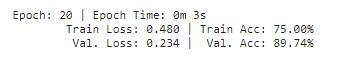

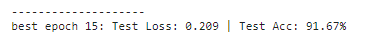

- mobilenet_v2

image.png

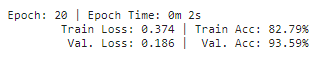

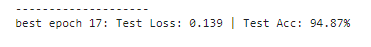





- efficientnet_b1

image.png

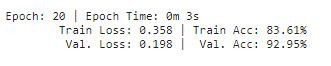

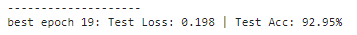

- mnasnet0_5

image.png

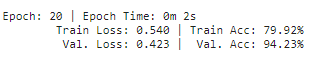

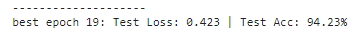

- shufflenet_v2_x0_5

image.png

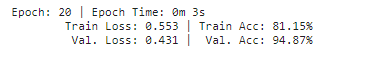

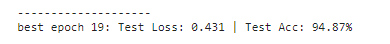

Время затраченное на эпоху в среднем одинаковое для каждой модели и находится в диапазоне от 2-3 секунд

Также можно пронаблюдать такую зависимость, что у googlenet порядка 6 млн параметров, efficientnet_b1 - 7 млн параметров, однако они уступают по точности остальным моделям. Остальные модели - shufflenet_v2_x0_5, mnasnet0_5, mobilenet_v2 показали практически одинаковые результаты и их точность составила 94%

## 5. Попытайтесь натренировать полную модель resnet18 c предобученными весами и без них (то есьт все слои надо разморозить)

### Рассмотрим вариант с предобученными весами

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name,_ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 11177538
Number of all parameters for the model: 11177538


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 1.074 | Test Acc: 44.87%


In [ ]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.536 | Train Acc: 75.41%
	 Val. Loss: 0.234 |  Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.527 | Train Acc: 75.82%
	 Val. Loss: 0.199 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.551 | Train Acc: 75.41%
	 Val. Loss: 0.217 |  Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.452 | Train Acc: 81.97%
	 Val. Loss: 0.203 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.392 | Train Acc: 81.15%
	 Val. Loss: 0.181 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.329 | Train Acc: 84.02%
	 Val. Loss: 0.199 |  Val. Acc: 94.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.396 | Train Acc: 83.61%
	 Val. Loss: 0.213 |  Val. Acc: 93.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.458 | Train Acc: 79.51%
	 Val. Loss: 0.235 |  Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.350 | Train Acc: 82.79%
	 Val. Loss: 0.187 |  Val. Acc: 94.87%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.377 | Train Acc: 83.61%
	 Val. Loss: 0.190 |  Val. Acc: 94.87%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 18: Test Loss: 0.180 | Test Acc: 95.51%


Полученная точность на тестовой выборке превосходит результаты моделнй, которые были рассмотренны в пункте 3

### Вариант без предобученных весов

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = True

In [ ]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 11177538
Number of all parameters for the model: 11177538


In [ ]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

In [ ]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)


trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

In [ ]:
EPOCHS = 80

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                trainloader,
                                                optimizer,
                                                criterion,
                                                accuracy,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   valloader,
                                                   criterion,
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.765 | Train Acc: 56.15%
	 Val. Loss: 0.725 |  Val. Acc: 65.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.758 | Train Acc: 55.74%
	 Val. Loss: 0.674 |  Val. Acc: 58.97%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.780 | Train Acc: 53.28%
	 Val. Loss: 0.674 |  Val. Acc: 64.74%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.666 | Train Acc: 62.30%
	 Val. Loss: 1.231 |  Val. Acc: 59.62%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.735 | Train Acc: 60.25%
	 Val. Loss: 1.321 |  Val. Acc: 55.13%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 3s
	Train Loss: 0.671 | Train Acc: 65.16%
	 Val. Loss: 0.834 |  Val. Acc: 67.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 3s
	Train Loss: 0.741 | Train Acc: 62.70%
	 Val. Loss: 0.827 |  Val. Acc: 66.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 3s
	Train Loss: 0.654 | Train Acc: 63.11%
	 Val. Loss: 0.725 |  Val. Acc: 65.38%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 3s
	Train Loss: 0.797 | Train Acc: 58.20%
	 Val. Loss: 1.108 |  Val. Acc: 61.54%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 3s
	Train Loss: 0.758 | Train Acc: 61.07%
	 Val. Loss: 0.580 |  Val. Acc: 75.64%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 3s
	Train Loss: 0.681 | Train Acc: 66.80%
	 Val. Loss: 0.546 |  Val. Acc: 74.36%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 3s
	Train Loss: 0.702 | Train Acc: 65.57%
	 Val. Loss: 0.689 |  Val. Acc: 69.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 3s
	Train Loss: 0.718 | Train Acc: 68.03%
	 Val. Loss: 0.759 |  Val. Acc: 64.74%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 3s
	Train Loss: 0.681 | Train Acc: 65.98%
	 Val. Loss: 0.706 |  Val. Acc: 68.59%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 3s
	Train Loss: 0.651 | Train Acc: 68.03%
	 Val. Loss: 0.605 |  Val. Acc: 73.72%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 3s
	Train Loss: 0.578 | Train Acc: 69.67%
	 Val. Loss: 0.768 |  Val. Acc: 66.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 3s
	Train Loss: 0.607 | Train Acc: 70.08%
	 Val. Loss: 0.581 |  Val. Acc: 71.79%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 3s
	Train Loss: 0.564 | Train Acc: 72.95%
	 Val. Loss: 0.871 |  Val. Acc: 62.82%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 3s
	Train Loss: 0.575 | Train Acc: 72.95%
	 Val. Loss: 1.191 |  Val. Acc: 51.92%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 3s
	Train Loss: 0.595 | Train Acc: 69.67%
	 Val. Loss: 0.680 |  Val. Acc: 75.00%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 3s
	Train Loss: 0.630 | Train Acc: 68.44%
	 Val. Loss: 0.819 |  Val. Acc: 60.26%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 3s
	Train Loss: 0.632 | Train Acc: 65.57%
	 Val. Loss: 0.600 |  Val. Acc: 69.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 3s
	Train Loss: 0.621 | Train Acc: 66.80%
	 Val. Loss: 0.667 |  Val. Acc: 71.15%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 3s
	Train Loss: 0.597 | Train Acc: 72.13%
	 Val. Loss: 0.573 |  Val. Acc: 77.56%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 3s
	Train Loss: 0.632 | Train Acc: 67.21%
	 Val. Loss: 0.654 |  Val. Acc: 71.15%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 0m 3s
	Train Loss: 0.548 | Train Acc: 70.90%
	 Val. Loss: 0.614 |  Val. Acc: 73.72%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 0m 3s
	Train Loss: 0.598 | Train Acc: 68.85%
	 Val. Loss: 0.623 |  Val. Acc: 73.72%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 0m 3s
	Train Loss: 0.735 | Train Acc: 64.34%
	 Val. Loss: 0.740 |  Val. Acc: 64.10%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 0m 3s
	Train Loss: 0.549 | Train Acc: 72.54%
	 Val. Loss: 1.060 |  Val. Acc: 58.33%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 0m 3s
	Train Loss: 0.660 | Train Acc: 69.67%
	 Val. Loss: 0.644 |  Val. Acc: 67.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 0m 3s
	Train Loss: 0.572 | Train Acc: 74.59%
	 Val. Loss: 0.600 |  Val. Acc: 75.64%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 0m 3s
	Train Loss: 0.540 | Train Acc: 76.23%
	 Val. Loss: 0.631 |  Val. Acc: 66.67%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 0m 3s
	Train Loss: 0.613 | Train Acc: 72.54%
	 Val. Loss: 1.111 |  Val. Acc: 67.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 0m 3s
	Train Loss: 0.690 | Train Acc: 70.90%
	 Val. Loss: 0.753 |  Val. Acc: 62.18%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 70 | Epoch Time: 0m 3s
	Train Loss: 0.500 | Train Acc: 74.59%
	 Val. Loss: 0.667 |  Val. Acc: 75.00%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 72 | Epoch Time: 0m 3s
	Train Loss: 0.565 | Train Acc: 75.41%
	 Val. Loss: 0.658 |  Val. Acc: 73.08%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 74 | Epoch Time: 0m 3s
	Train Loss: 0.496 | Train Acc: 77.46%
	 Val. Loss: 0.635 |  Val. Acc: 74.36%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 76 | Epoch Time: 0m 3s
	Train Loss: 0.511 | Train Acc: 71.72%
	 Val. Loss: 0.766 |  Val. Acc: 69.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 78 | Epoch Time: 0m 3s
	Train Loss: 0.620 | Train Acc: 72.54%
	 Val. Loss: 1.207 |  Val. Acc: 60.26%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 80 | Epoch Time: 0m 3s
	Train Loss: 0.607 | Train Acc: 70.08%
	 Val. Loss: 2.309 |  Val. Acc: 48.08%


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 64: Test Loss: 0.508 | Test Acc: 76.92%


Видно, что качество ухудшилось, по сравнению с уже обучеными весами модели. Это связано с тем, что  модели обучались на больших наборах данных. В нашем же случае может оказаться так, что модели не достаточно данных для обучения (поскольку также в качестве анализа данная модель запускалась на 200 эпохах и тточность не изменилась -77%)